In [1]:
import numpy as np
import theano
import theano.tensor as T

Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
def variance_inverse(covariance_tensor):
    inverted,_ = theano.map(
            T.nlinalg.matrix_inverse,
            sequences = [covariance_tensor]
    )
    return inverted

In [110]:
def build(params,name,phonemes,components,rows,cols):
    n_hidden = rows * cols
    mean_arr = np.zeros((phonemes,components,2))
    mean_arr[:,0,:] = [ 7.5, 7.5]
    mean_arr[:,1,:] = [ 7.5,22.5]
    mean_arr[:,2,:] = [22.5, 7.5]
    mean_arr[:,3,:] = [22.5,22.5]

    phoneme_mixtures = theano.shared(
                            np.ones((phonemes,components))/components
                        )                       # phonemes x components
    phoneme_means    = theano.shared(mean_arr)  # phonemes x components x 2
    phoneme_var      = theano.shared(
                            np.array(phonemes * [
                                components * [ np.eye(2) ]
                            ])
                        )                       # phonemes x components x 2 x 2

	phoneme_precisions = variance_inverse(
			phoneme_var.reshape((phonemes * components,2,2))
		).reshape((phonemes,components,2,2))

	points = theano.shared(np.dstack(np.meshgrid(
		np.arange(cols),np.arange(rows)
	)).reshape(n_hidden,2))												# n_hidden x 2

	phoneme_means_      = phoneme_means.dimshuffle(0,1,'x',2)			# phonemes x components x 1 x 2
	phoneme_precisions_ = phoneme_precisions.dimshuffle(0,1,'x',2,3)	# phonemes x components x 1 x 2 x 2
	phoneme_mixtures_   = phoneme_mixtures.dimshuffle(0,1,'x')
	points_ = points.dimshuffle('x','x',0,1)							# 1 x 1 x n_hidden x 2
	deviations = points_ - phoneme_means_ 								# phonemes x components x n_hidden x 2
	deviations_ = deviations.dimshuffle(0,1,2,'x',3)					# phonemes x components x n_hidden x 1 x 2
	normalised_deviations = T.sum(phoneme_precisions_ * deviations_,axis=3)		# phonemes x components x n_hidden x 2 
	gaussians = T.exp(-T.sum(normalised_deviations**2,axis=3))			# phonemes x components x n_hidden
	norm_gaussians = gaussians / T.sum(gaussians,axis=2).dimshuffle(0,1,'x') 

	mog = T.sum(norm_gaussians * phoneme_mixtures_,axis=1)


	def constraint(hidden,phonemes):
		surface = mog[phonemes]  # N x n_hidden
		norm_hidden = hidden / T.sum(hidden,axis=1).dimshuffle(0,'x')
		return -mog[phonemes] * T.log(hidden)
		
	stats_w_acc    = theano.shared(np.zeros((phonemes,components)))		# phonemes x components
	stats_mean_acc = theano.shared(np.zeros((phonemes,components,2)))	# phonemes x components x 2
	stats_var_acc  = theano.shared(np.zeros((phonemes,components,2,2)))	# phonemes x components x 2 x 2

	def updates(hidden,phonemes):
		frame_gaussians = norm_gaussians[phonemes] 	# N x components x n_hidden
		hidden_ = hidden.dimshuffle(0,'x',1)		# N x n_hidden x 1
		gamma   = frame_gaussians / T.sum(frame_gaussians,axis=1).dimshuffle(0,'x',1) # N x components x n_hidden
		contribution   = gamma * hidden_					# N x components x n_hidden
		contribution_  = contribution.dimshuffle(0,1,2,'x')	  # N x components x n_hidden x 1
		contribution__ = contribution.dimshuffle(0,1,2,'x','x') # N x components x n_hidden x 1 x 1
		point_contri = contribution_ *  points_  # N x components x n_hidden x 2
		vari_contri = point_contri.dimshuffle(0,1,2,3,'x') \
					* point_contri.dimshuffle(0,1,2,'x',3)

		stats_w    = T.sum(contribution,axis=2) # N x components
		stats_mean = T.sum(point_contri,axis=2) # N x components x 2
		stats_var  = T.sum(vari_contri,axis=2)  # N x components x 2 x 2

		stats_updates = [
			(stats_w_acc,    T.inc_subtensor(stats_w_acc[phonemes],stats_w)),
			(stats_mean_acc, T.inc_subtensor(stats_mean_acc[phonemes],stats_mean)),
			(stats_var_acc , T.inc_subtensor(stats_var_acc[phonemes],stats_var)),
		]
		eps = 1e-8
		stats_w_acc_ = stats_w_acc.dimshuffle(0,1,'x')
		stats_w_acc__ = stats_w_acc.dimshuffle(0,1,'x','x')
		phoneme_mixture_update = (stats_w_acc + eps) / T.sum(stats_w_acc + eps,axis=1).dimshuffle(0,'x')
		phoneme_mean_update = (stats_mean_acc + eps) / (stats_w_acc_ + eps)
		phoneme_mean_sq = phoneme_mean_update.dimshuffle(0,1,'x',2) \
						* phoneme_mean_update.dimshuffle(0,1,2,'x') 
		phoneme_var_update =  stats_var_acc / stats_w_acc__ - phoneme_mean_sq
		param_updates = [
			(phoneme_mixtures, phoneme_mixture_update),
			(phoneme_means,    phoneme_mean_update),
			(phoneme_var,      phoneme_var_update),
			(stats_w_acc,      0. * stats_w_acc),
			(stats_mean_acc,   0. * stats_mean_acc),
			(stats_var_acc ,   0. * stats_var_acc),
		]
        
		return stats_updates,param_updates

		
	params["phoneme_mixtures_%s"%name] = phoneme_mixtures
	params["phoneme_means_%s"%name]    = phoneme_means
	params["phoneme_var_%s"%name]      = phoneme_var
	phoneme_mixtures.name = "phoneme_mixtures_%s"%name
	phoneme_means.name = "phoneme_means_%s"%name
	phoneme_var.name = "phoneme_var_%s"%name

	return constraint,updates,mog

In [111]:
phoneme_means_      = phoneme_means.dimshuffle(0,1,'x',2)			# phonemes x components x 1 x 2
phoneme_precisions_ = phoneme_precisions.dimshuffle(0,1,'x',2,3)	# phonemes x components x 1 x 2 x 2
phoneme_mixtures_   = phoneme_mixtures.dimshuffle(0,1,'x')
points_ = points.dimshuffle('x','x',0,1)							# 1 x 1 x n_hidden x 2
deviations = points_ - phoneme_means_ 								# phonemes x components x n_hidden x 2
deviations_ = deviations.dimshuffle(0,1,2,'x',3)					# phonemes x components x n_hidden x 1 x 2
normalised_deviations = T.sum(phoneme_precisions_ * deviations_,axis=3)		# phonemes x components x n_hidden x 2 
gaussians = T.exp(-T.sum(normalised_deviations**2,axis=3))			# phonemes x components x n_hidden
norm_gaussians = gaussians / T.sum(gaussians,axis=2).dimshuffle(0,1,'x')
mog = T.sum(norm_gaussians * phoneme_mixtures_,axis=1)

In [112]:
gaussians = norm_gaussians.eval()

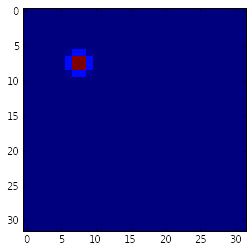

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(gaussians[0,0].reshape(32,32),interpolation="nearest") #gaussian creation seems to be working

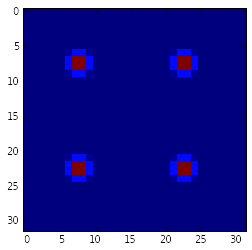

In [114]:
mog = T.sum(norm_gaussians * phoneme_mixtures_,axis=1)
mog_data = mog.eval()
plt.imshow(mog_data[0].reshape(32,32),interpolation="nearest")

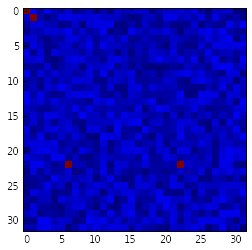

In [147]:
data = np.zeros((128,1024),dtype=np.float32)
data += np.random.rand(128,1024)
data[:,32 * 0 + 0] = 10
data[:,32 * 22 + 6] = 10
data[:,32 * 22 + 22] = 10
data[:,32 * 1 + 1] = 10

hidden   = theano.shared(data)
phonemes = theano.shared(np.zeros((128,),dtype=np.int32))
plt.imshow(data[0].reshape(32,32),interpolation="nearest") #data generation seems to be working

In [148]:
frame_gaussians = norm_gaussians[phonemes]  # N x components x n_hidden
hidden_ = hidden.dimshuffle(0,'x',1)        # N x 1 x n_hidden 
gamma   = frame_gaussians / T.sum(frame_gaussians,axis=1).dimshuffle(0,'x',1) # N x components x n_hidden
contribution   = gamma * hidden_            # N x components x n_hidden
contribution_  = contribution.dimshuffle(0,1,2,'x')	  # N x components x n_hidden x 1
contribution__ = contribution.dimshuffle(0,1,2,'x','x') # N x components x n_hidden x 1 x 1
point_contri = contribution_ *  points_  # N x components x n_hidden x 2
vari_contri = point_contri.dimshuffle(0,1,2,3,'x') \
            * point_contri.dimshuffle(0,1,2,'x',3)



(128, 4, 1024)


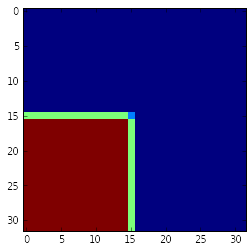

In [149]:
g = gamma.eval()
print g.shape
plt.imshow(g[0,2,:].reshape(32,32),interpolation="nearest") # so we know gamma works

(128, 4, 1024)
10.0


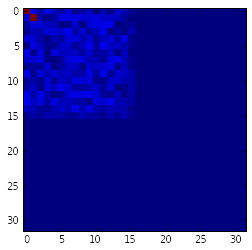

In [150]:
c = contribution.eval()
print c.shape
print np.max(c)
plt.imshow(c[0,0,:].reshape(32,32),interpolation="nearest") # so we know contribution works

In [151]:
stats_w    = T.sum(contribution,axis=2) # N x components
stats_mean = T.sum(point_contri,axis=2) # N x components x 2
stats_var  = T.sum(vari_contri,axis=2)  # N x components x 2 x 2
stats_w_acc1 = T.inc_subtensor(stats_w_acc[phonemes],stats_w)
stats_mean_acc1 = T.inc_subtensor(stats_mean_acc[phonemes],stats_mean)
stats_var_acc1 = T.inc_subtensor(stats_var_acc[phonemes],stats_var)

In [152]:
phoneme_mixture_update = stats_w_acc1 / T.sum(stats_w_acc1,axis=1).dimshuffle(0,'x')
phoneme_mixture_update.eval()

array([[ 0.25341905,  0.233432  ,  0.24971682,  0.26343212]])

In [153]:
phoneme_mean_update = stats_mean_acc1 / stats_w_acc1.dimshuffle(0,1,'x')
phoneme_mean_update.eval()

array([[[  6.33461107,   6.34599769],
        [ 23.25200686,   7.26031222],
        [  7.19145142,  23.15861665],
        [ 23.16112824,  23.16692868]]])